In [1]:
import sys

sys.path.append('/home/radlr/anaconda3/envs/lVGPU2/lib/python3.6/site-packages')

#hint from https://stackoverflow.com/questions/19876079/opencv-cannot-find-module-cv2

In [2]:
# math etc.
from scipy import misc
import numpy as np

#plotting
import matplotlib as mpl
from matplotlib import pyplot as plt

#image functions, esp. resizing
import cv2
#directory functions
import os

In [ ]:
def cuttleVision(cSpher,fN,nStk,off,defAtt):
    img = 1.0*misc.imread(fN)
    sBNarrower = 1.0*misc.imread('./sBandiensisNarrower-1.tif')
    sBNarrow = 1.0*misc.imread('./sBandiensisNarrow-1.tif')
    sBFull = 1.0*misc.imread('./sBandiensisFuller-1.tif')
    
    dimX = np.shape(sBNarrower)[0]
    mid = dimX/2
    dimImg = np.shape(img)[0]
    
    N = 12.5 #25mm eye
    x1, y1 = np.meshgrid(np.arange(-N,N-N/dimX,2*N/dimX),np.arange(-N,N-N/dimX,2*N/dimX))
    
    rad = np.sqrt(x1**2+y1**2)
    
    apDef = np.exp(np.sqrt(3)*(2*rad**2-1))
    apSpher = np.exp(np.sqrt(5) * (6*rad**4 - 6*rad**2+1))
    
    nStk = 2 # three focus depths
    
    
    imgStack = np.zeros([dimImg,dimImg,3])
    
    myPSFDim = 48
    PSF = np.zeros([myPSFDim*2,myPSFDim*2,9])
    
    for c in range(0,nStk+1):
        
        cChromR = 1 - (c / (nStk))
        cChromB = 1.0 - cChromR
        cChromG = 0.5 - cChromR
        if (0):
            apR1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromR*defAtt*apDef+cSpher*apSpher));
            apG1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromG*defAtt*apDef+cSpher*apSpher));
            apB1 = (sBNarrow) * np.exp(1j*2*np.pi*(cChromB*defAtt*apDef+cSpher*apSpher));
        if(1):
            apR1 = (sBFull) * np.exp(1j*2*np.pi*(cChromR*defAtt*apDef+cSpher*apSpher));
            apG1 = (sBFull) * np.exp(1j*2*np.pi*(cChromG*defAtt*apDef+cSpher*apSpher));
            apB1 = (sBFull) * np.exp(1j*2*np.pi*(cChromB*defAtt*apDef+cSpher*apSpher));
        
        apR1 = np.nan_to_num(apR1)
        apG1 = np.nan_to_num(apG1)
        apB1 = np.nan_to_num(apB1)
                
        PSF1R = np.abs(np.fft.fft2(apR1))**2
        PSF1G = np.abs(np.fft.fft2(apG1))**2
        PSF1B = np.abs(np.fft.fft2(apB1))**2
        
        #normalize PSFs
        if (0):
            PSF1R = PSF1R/np.max(np.max(PSF1R)); #%abs(fft(apR1)).^2;
            PSF1G = PSF1G/np.max(np.max(PSF1G));
            PSF1B = PSF1B/np.max(np.max(PSF1B));
        
        tempR = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,0],[dimX,dimX])*np.fft.fft2(PSF1R)))
        tempG = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,1],[dimX,dimX])*np.fft.fft2(PSF1G)))
        tempB = np.abs(np.fft.ifft2(np.fft.fft2(img[:,:,2],[dimX,dimX])*np.fft.fft2(PSF1B)))
        
        tempR = (tempR - np.min(tempR)) / np.max(tempR)
        tempG = (tempG - np.min(tempG)) / np.max(tempG)
        tempB = (tempB - np.min(tempB)) / np.max(tempB)
        
        tempR = tempR[0:dimImg,0:dimImg]
        tempG = tempG[0:dimImg,0:dimImg]
        tempB = tempB[0:dimImg,0:dimImg]
        
        myPSFDim = 48
        PSF1R = np.fft.fftshift(PSF1R)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1G = np.fft.fftshift(PSF1G)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        PSF1B = np.fft.fftshift(PSF1B)[int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim,int(dimX/2)-myPSFDim:int(dimX/2)+myPSFDim]
        
        imgStack[:,:,c] = tempR + tempG + tempB
        if(0):
            imgStack[:,:,c*3+0] = tempR
            imgStack[:,:,c*3+1] = tempG
            imgStack[:,:,c*3+2] = tempB
        if(1):
            PSF[:,:,c*3+0] = PSF1R
            PSF[:,:,c*3+1] = PSF1G
            PSF[:,:,c*3+2] = PSF1B
        if (0): #plot for debugging/testing defocus parameters
            plt.figure(figsize=(12,12))
            plt.subplot(321)
            plt.imshow(tempR,cmap='gray')
            plt.subplot(322)
            plt.imshow(tempG,cmap='gray')
            plt.subplot(323)
            plt.imshow(tempB,cmap='gray')
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
            myImgRGB = np.zeros([dimImg,dimImg,3])
            myImgRGB[:,:,0] = tempR
            myImgRGB[:,:,1] = tempG
            myImgRGB[:,:,2] = tempB
            plt.figure(figsize=(6,6))
            plt.imshow(myImgRGB)
            #plt.figure()
            #plt.imshow(PSF1R)
            plt.show()
    return imgStack, PSF

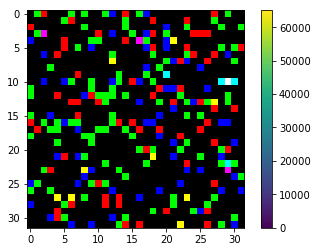

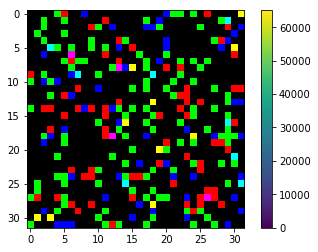

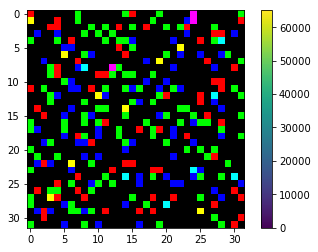

(1024, 32, 32, 3)


In [7]:
#Generate random RGB images

myDimSm = 32
myDimFl = 32
simgStkNo = 1024

#make it deterministic
np.random.seed(1)
simgStk = np.zeros([simgStkNo,myDimSm,myDimSm,3])
for c in range(0,simgStkNo):
    myTestR = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTestG = 255*( np.random.random([myDimSm,myDimSm]) < 0.125)
    myTestB = 255*( np.random.random([myDimSm,myDimSm]) < 0.07)
    myTest =np.zeros([myDimSm,myDimSm,3])
    myTest[:,:,0] = myTestR
    myTest[:,:,1] = myTestG
    myTest[:,:,2] = myTestB
    myTest = myTest*255
    simgStk[c] = myTest
    if(c % 500 == 0):

        plt.figure()

        plt.imshow(myTest)

        plt.colorbar()
        plt.show()

    
print(np.shape(simgStk))


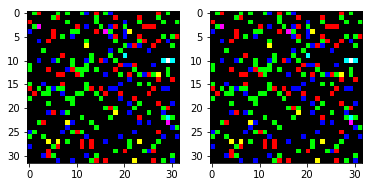

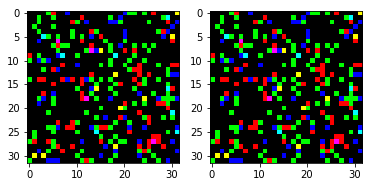

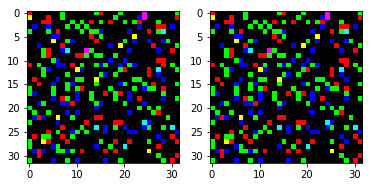

In [8]:
#Resize and store simulated RGB images

simgStkFl = np.zeros([simgStkNo,myDimFl,myDimFl,3])
for c in range(0,simgStkNo):
    myImg = simgStk[c]
    myDimX = np.shape(myImg)[0]
    myDimY = np.shape(myImg)[1]
    if (myDimX < myDimY):
        myDim = myDimX
    else:
        myDim = myDimY
    myImg = myImg[0:myDim,0:myDim,:]
    myResImg = cv2.resize(myImg,(myDimFl,myDimFl), interpolation = cv2.INTER_CUBIC)
    simgStkFl[c] = myResImg
    cv2.imwrite('./sImgs/simulatedImg'+str(c)+'.tif',myResImg)
    if(c % 500 == 0):

        plt.figure()

        plt.subplot(121)
        plt.imshow(simgStk[c])
        plt.subplot(122) 
        plt.imshow(myResImg)
        #plt.colorbar()
        plt.show()

In [9]:
#shape of the full image stack
print(np.shape(simgStkFl))

(1024, 32, 32, 3)


simulatedImg466.tif


/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
/home/radlr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: 

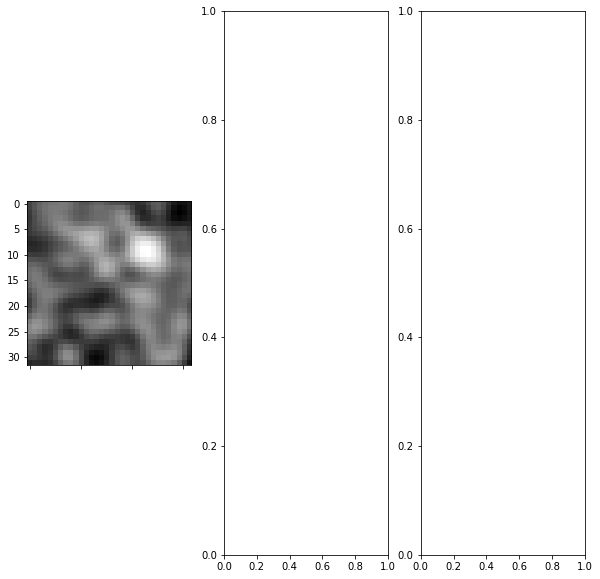

simulatedImg261.tif
simulatedImg420.tif
simulatedImg790.tif
simulatedImg241.tif
simulatedImg795.tif
simulatedImg272.tif
simulatedImg33.tif
simulatedImg945.tif
simulatedImg233.tif
simulatedImg93.tif
simulatedImg552.tif
simulatedImg12.tif
simulatedImg78.tif
simulatedImg158.tif
simulatedImg484.tif
simulatedImg335.tif
simulatedImg514.tif
simulatedImg184.tif
simulatedImg312.tif
simulatedImg344.tif
simulatedImg855.tif
simulatedImg453.tif
simulatedImg186.tif
simulatedImg38.tif
simulatedImg543.tif
simulatedImg488.tif
simulatedImg251.tif
simulatedImg554.tif
simulatedImg188.tif
simulatedImg91.tif
simulatedImg313.tif
simulatedImg979.tif
simulatedImg917.tif
simulatedImg432.tif
simulatedImg736.tif
simulatedImg276.tif
simulatedImg774.tif
simulatedImg204.tif
simulatedImg494.tif
simulatedImg574.tif
simulatedImg360.tif
simulatedImg168.tif
simulatedImg278.tif
simulatedImg1012.tif
simulatedImg402.tif
simulatedImg592.tif
simulatedImg209.tif
simulatedImg641.tif
simulatedImg127.tif
simulatedImg612.tif
simul

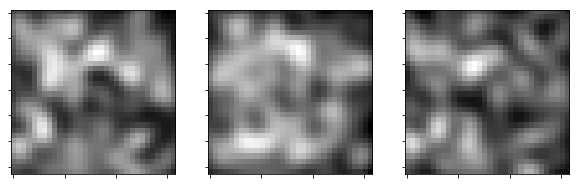

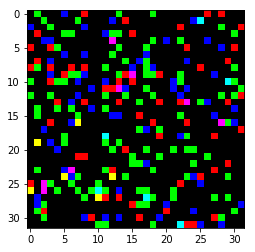

simulatedImg250.tif
simulatedImg470.tif
simulatedImg224.tif
simulatedImg896.tif
simulatedImg379.tif
simulatedImg520.tif
simulatedImg355.tif
simulatedImg32.tif
simulatedImg739.tif
simulatedImg832.tif
simulatedImg659.tif
simulatedImg388.tif
simulatedImg342.tif
simulatedImg24.tif
simulatedImg372.tif
simulatedImg854.tif
simulatedImg323.tif
simulatedImg259.tif
simulatedImg442.tif
simulatedImg1017.tif
simulatedImg764.tif
simulatedImg524.tif
simulatedImg643.tif
simulatedImg1011.tif
simulatedImg980.tif
simulatedImg829.tif
simulatedImg264.tif
simulatedImg36.tif
simulatedImg80.tif
simulatedImg852.tif
simulatedImg68.tif
simulatedImg671.tif
simulatedImg619.tif
simulatedImg460.tif
simulatedImg525.tif
simulatedImg538.tif
simulatedImg961.tif
simulatedImg885.tif
simulatedImg987.tif
simulatedImg429.tif
simulatedImg406.tif
simulatedImg691.tif
simulatedImg548.tif
simulatedImg597.tif
simulatedImg650.tif
simulatedImg403.tif
simulatedImg0.tif
simulatedImg476.tif
simulatedImg223.tif
simulatedImg541.tif
simul

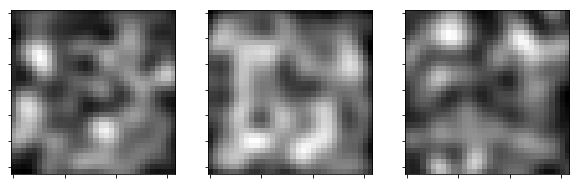

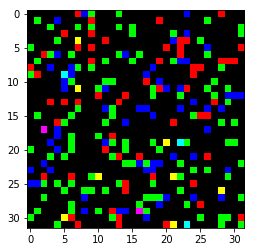

simulatedImg800.tif
simulatedImg411.tif
simulatedImg957.tif
simulatedImg20.tif
simulatedImg63.tif
simulatedImg569.tif
simulatedImg450.tif
simulatedImg322.tif
simulatedImg207.tif
simulatedImg551.tif
simulatedImg667.tif
simulatedImg866.tif
simulatedImg724.tif
simulatedImg634.tif
simulatedImg783.tif
simulatedImg708.tif
simulatedImg586.tif
simulatedImg738.tif
simulatedImg190.tif
simulatedImg267.tif
simulatedImg292.tif
simulatedImg1007.tif
simulatedImg157.tif
simulatedImg8.tif
simulatedImg1009.tif
simulatedImg771.tif
simulatedImg745.tif
simulatedImg621.tif
simulatedImg954.tif
simulatedImg285.tif
simulatedImg117.tif
simulatedImg49.tif
simulatedImg815.tif
simulatedImg570.tif
simulatedImg148.tif
simulatedImg646.tif
simulatedImg310.tif
simulatedImg143.tif
simulatedImg327.tif
simulatedImg300.tif
simulatedImg948.tif
simulatedImg159.tif
simulatedImg940.tif
simulatedImg178.tif
simulatedImg349.tif
simulatedImg66.tif
simulatedImg904.tif
simulatedImg254.tif
simulatedImg864.tif
simulatedImg195.tif
simu

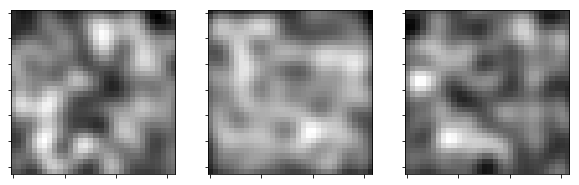

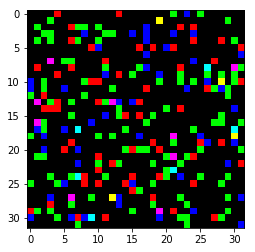

simulatedImg173.tif
simulatedImg651.tif
simulatedImg673.tif
simulatedImg128.tif
simulatedImg844.tif
simulatedImg350.tif
simulatedImg817.tif
simulatedImg636.tif
simulatedImg320.tif
simulatedImg311.tif
simulatedImg539.tif
simulatedImg270.tif
simulatedImg869.tif
simulatedImg303.tif
simulatedImg666.tif
simulatedImg725.tif
simulatedImg496.tif
simulatedImg919.tif
simulatedImg163.tif
simulatedImg535.tif
simulatedImg637.tif
simulatedImg199.tif
simulatedImg200.tif
simulatedImg86.tif
simulatedImg772.tif
simulatedImg364.tif
simulatedImg886.tif
simulatedImg305.tif
simulatedImg769.tif
simulatedImg83.tif
simulatedImg90.tif
simulatedImg53.tif
simulatedImg111.tif
simulatedImg766.tif
simulatedImg211.tif
simulatedImg602.tif
simulatedImg686.tif
simulatedImg509.tif
simulatedImg791.tif
simulatedImg218.tif
simulatedImg31.tif
simulatedImg299.tif
simulatedImg868.tif
simulatedImg585.tif
simulatedImg614.tif
simulatedImg759.tif
simulatedImg219.tif
simulatedImg652.tif
simulatedImg620.tif
simulatedImg189.tif
simul

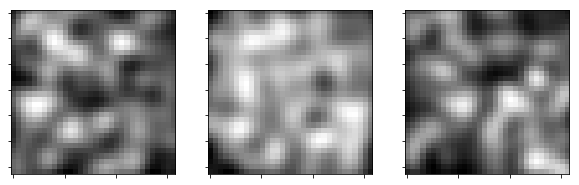

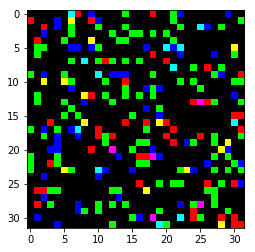

Target vector shape:  (1024, 32, 32, 3)
Training vector shape:  (1024, 32, 32, 3)


In [19]:
# The full-size simulated RGB image stack is the training target
# now to create an input stack using the cuttleVision function

myMiniDir = os.listdir('./sImgs/')
cSpher = 0
nStk = 3
off = 0
defAtt = 900
myTargets = []
myImgs = []

#note cv2 to color function for displaying RGB images
#opencv store images as BGR instead of RGB, so we have to fix it
#cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB)
myC = 0 
for k in myMiniDir:
    myC = myC+1 
    #myImg = cv2.imread('./sImgs/' + str(c))
    print(k)
    #Compute cuttlevision
    imgStk, PSFStk = cuttleVision(cSpher,'./sImgs/'+str(k),nStk,off,defAtt)
    #Load target image
    myImg = cv2.imread('./sImgs/'+str(k))
    myImgs.append(imgStk)
    myTargets.append(myImg)
    
    if (( myC % 256)==0):
        myFig, myAxes = plt.subplots(1,3,figsize=(10,10))
        for c in range(0,4):
            #for x in range(0,3):
            #plt.subplot(3,3,c+1)
            if(c < 3):
                myAxes[c].imshow(imgStk[:,:,c],cmap="gray")
                myAxes[c].set_xticklabels([])
                myAxes[c].set_yticklabels([])
            else:
                plt.figure()
                plt.imshow(cv2.cvtColor(myImg, cv2.COLOR_BGR2RGB))
                #myAxes[c].set_xticklabels([])
                #myAxes[c].set_yticklabels([])
            #plt.tight_layout()
        
    
    plt.show()
    
print("Target vector shape: ", np.shape(myTargets))
print("Training vector shape: ", np.shape(myImgs))
            
        
                                           

In [20]:
%store myImgs
%store myTargets
print("Targets and training stored")

Stored 'myImgs' (list)
Stored 'myTargets' (list)
Targets and training stored


In [31]:
%store -r myImgs
%store -r myTargets
print(np.shape(myImgs))
print(np.shape(myTargets))
myImgs = np.array(myImgs)
myTargets = np.array(myTargets)

trainWide = np.zeros([np.shape(myImgs)[0],np.shape(myImgs)[1],np.shape(myImgs)[2]*3])
targetWide = np.zeros([np.shape(myImgs)[0],np.shape(myImgs)[1],np.shape(myImgs)[2]*3])

numSamples = 1024
print(np.shape(trainWide), ' ', np.shape(targetWide))

trainWide = np.reshape(myImgs,[numSamples,myDimFl*myDimFl*3],'F')

#targetWide = np.reshape(myTargets,[numSamples,myDimFl*myDimFl*3],'F')
print(np.shape(trainWide.T))
if(1):
    plt.figure()
    plt.imshow(trainWide[500,:],cmap='gray')
    plt.show()
    plt.figure()
    plt.subplot(131)
    plt.imshow(myImgs[500,:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(myImgs[500,:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(myImgs[500,:,:,2],cmap='gray')
    plt.show()

(1024, 32, 32, 3)
(1024, 32, 32, 3)
(1024, 32, 96)   (1024, 32, 96)
(3072, 1024)


TypeError: Invalid dimensions for image data

Instructions for updating:
Use `tf.global_variables_initializer` instead.
iteration  19999  with cost  20.2764
(10, 3072)
(10, 3072)
Targets subset >


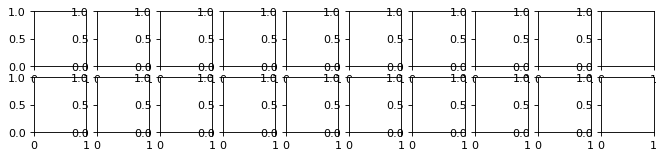

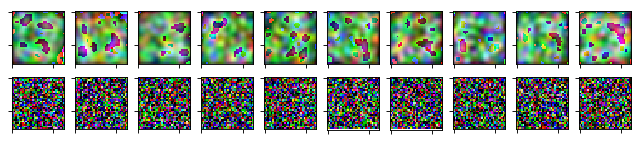

Guesses subset ^^
elapsed time  627.032347202301  s
iteration  39999  with cost  19.2546
(10, 3072)
(10, 3072)
Targets subset >


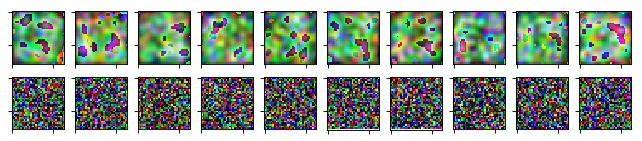

Guesses subset ^^
elapsed time  2036.8065345287323  s
iteration  59999  with cost  18.7618
(10, 3072)
(10, 3072)
Targets subset >


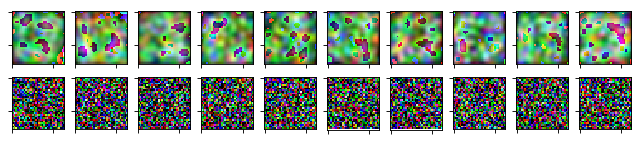

Guesses subset ^^
elapsed time  3571.5558071136475  s
iteration  79999  with cost  17.9588
(10, 3072)
(10, 3072)
Targets subset >


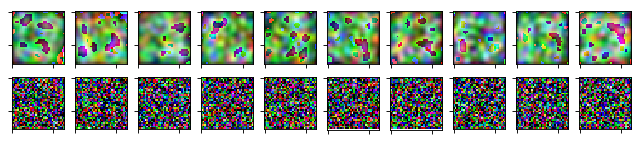

Guesses subset ^^
elapsed time  5101.128041744232  s
iteration  99999  with cost  17.5915
(10, 3072)
(10, 3072)
Targets subset >


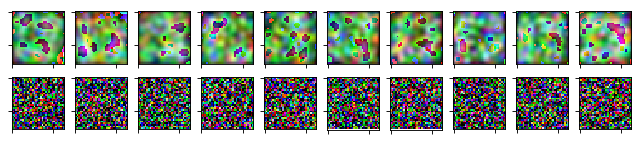

Guesses subset ^^
elapsed time  6636.040638208389  s


In [107]:
"""Following along from Siraj: https://github.com/llSourcell/autoencoder_demo/blob/master/main.py"""
import tensorflow as tf
import time
t = time.time()

imgWidth = 32
imgHeight = 32
n_visible = imgWidth *imgHeight*3
n_hidden = 1024 # hidden units
lR = 1e-7
myIter = int(1e5)
dispIt = 2e4 # display every th iteration
dORate = 0.33 # dropout Rate

corruption_level = 0.0

# create node for input data and corruption mask
X = tf.placeholder("float",[None, n_visibleRGB], name='X')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
W_init = tf.random_uniform(shape=[n_visibleRGB,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W = tf.Variable(W_init, name='W')
b = tf.Variable(tf.zeros([n_hidden]),name='b')

w_prime = tf.transpose(W)
b_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')

def model(X, W, b, W_prime, b_prime):
    tilde_X = X #
    Y = tf.nn.relu(tf.matmul(tilde_X, W) + b)
    #print(np.shape(Y))
    dO1 = tf.nn.dropout(Y,dORate)
    #print(np.shape(dO1))
    Z = tf.nn.relu(tf.matmul(dO1,W_prime) + b_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return Z

Z = model(X, W, b, w_prime, b_prime)

cost = tf.sqrt(tf.reduce_mean(tf.pow(X - Z, 2)))
train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

#trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])

trX = np.reshape(myImgs[0:800,:,:,:],[np.shape(myImgs[0:800,:,:,:])[0],n_visibleRGB])
teX = np.reshape(myImgs[801:1023,:,:,:],[np.shape(myImgs[801:1023:,:,:])[0],n_visibleRGB])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {X: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( (1+i) % dispIt == 0):
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={X: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(Z,feed_dict = {X: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight,3)),cmap="gray")
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight,3)),cmap="gray")
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")


    

In [101]:
print(np.shape(myImgs))

(1024, 32, 32, 3)


Instructions for updating:
Use `tf.global_variables_initializer` instead.
iteration  9999  with cost  40.746
(10, 3072)
(10, 3072)
Targets subset >


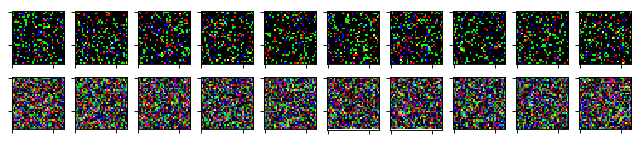

Guesses subset ^^
elapsed time  353.6266276836395  s
iteration  19999  with cost  37.9137
(10, 3072)
(10, 3072)
Targets subset >


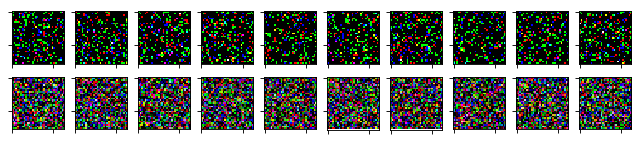

Guesses subset ^^
elapsed time  740.1682126522064  s
iteration  29999  with cost  35.5588
(10, 3072)
(10, 3072)
Targets subset >


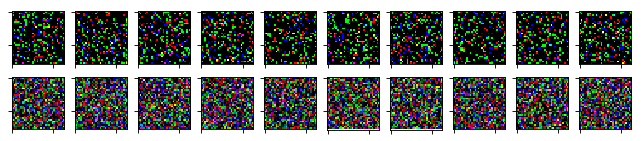

Guesses subset ^^
elapsed time  1065.2534856796265  s
iteration  39999  with cost  33.9128
(10, 3072)
(10, 3072)
Targets subset >


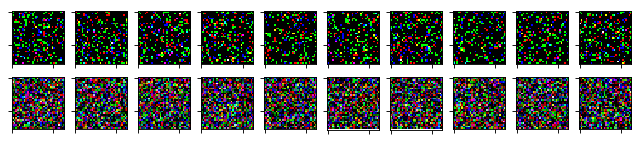

Guesses subset ^^
elapsed time  1396.4507706165314  s
iteration  49999  with cost  32.002
(10, 3072)
(10, 3072)
Targets subset >


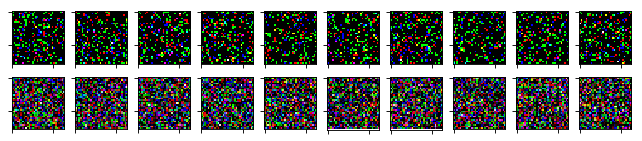

Guesses subset ^^
elapsed time  1726.2234179973602  s
iteration  59999  with cost  30.4949
(10, 3072)
(10, 3072)
Targets subset >


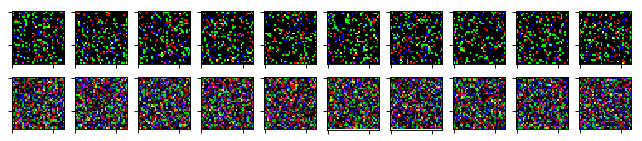

Guesses subset ^^
elapsed time  2055.9312806129456  s
iteration  69999  with cost  29.2952
(10, 3072)
(10, 3072)
Targets subset >


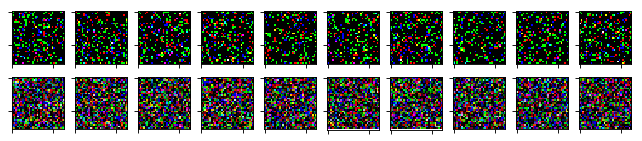

Guesses subset ^^
elapsed time  2386.932697057724  s
iteration  79999  with cost  28.0359
(10, 3072)
(10, 3072)
Targets subset >


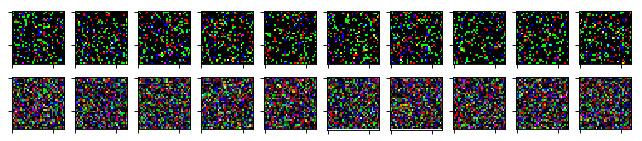

Guesses subset ^^
elapsed time  2722.087878227234  s
iteration  89999  with cost  26.8891
(10, 3072)
(10, 3072)
Targets subset >


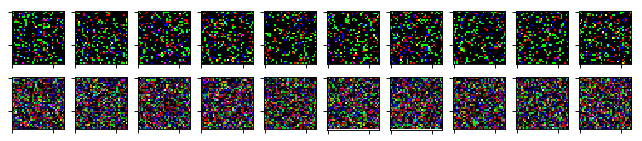

Guesses subset ^^
elapsed time  3052.9192967414856  s
iteration  99999  with cost  25.9427
(10, 3072)
(10, 3072)
Targets subset >


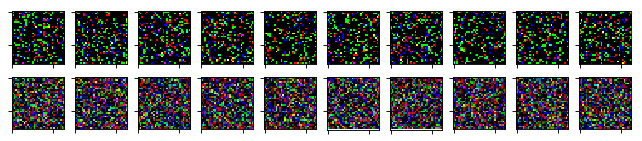

Guesses subset ^^
elapsed time  3384.754425764084  s


In [99]:
"""This version is an autoencoder for the RGB images (eventual targets for cuttleVision)
These heads will later be swapped"""

import tensorflow as tf
import time
t = time.time()

imgWidth = 32
imgHeight = 32
n_visibleRGB = 3*imgWidth *imgHeight
n_hidden = 1024 # hidden units
lR = 1e-5
myIter = int(1e5)
dispIt = 1e4 # display every th iteration
dORate = 0.33 # dropout Rate

corruption_level = 0.0

# create node for input data and corruption mask
XRGB = tf.placeholder("float",[None, n_visibleRGB], name='XRGB')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
WRGB_init = tf.random_uniform(shape=[n_visibleRGB,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

WRGB = tf.Variable(WRGB_init, name='WRGB')
bRGB = tf.Variable(tf.zeros([n_hidden]),name='bRGB')

wRGB_prime = tf.transpose(WRGB)
bRGB_prime = tf.Variable(tf.zeros([n_visibleRGB]), name='bRGB_prime')

def model(XRGB, WRGB, bRGB, WRGB_prime, bRGB_prime):
    tilde_X = XRGB #
    Y = tf.nn.relu(tf.matmul(tilde_X, WRGB) + bRGB)
    #print(np.shape(Y))
    dO1 = tf.nn.dropout(Y,dORate)
    #print(np.shape(dO1))
    ZRGB = tf.nn.relu(tf.matmul(dO1,WRGB_prime) + bRGB_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return ZRGB

ZRGB = model(XRGB, WRGB, bRGB, wRGB_prime, bRGB_prime)

cost = tf.sqrt(tf.sqrt(tf.reduce_mean(tf.pow(XRGB - ZRGB, 2))))
train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

#trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])
trX = np.reshape(myTargets[0:800,:,:,:],[np.shape(myTargets[0:800,:,:,:])[0],n_visibleRGB])
teX = np.reshape(myTargets[801:1023,:,:,:],[np.shape(myTargets[801:1023:,:,:])[0],n_visibleRGB])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {XRGB: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( (1+i) % dispIt == 0):
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={XRGB: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(ZRGB,feed_dict = {XRGB: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight,3)))
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight,3)))
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")


    

In [96]:
np.sqrt(4)

2.0

In [ ]:
"""5 hidden layer autoencoder""""
import tensorflow as tf
import time
t = time.time()

imgWidth = 32
imgHeight = 32
n_visible = imgWidth *imgHeight
n_hidden = 512 # hidden units
lR = 1e-8
myIter = int(2e3)
dispIt = 2e2 # display every th iteration
dORate = 0.33 # dropout Rate

# create node for input data and corruption mask
X = tf.placeholder("float",[None, n_visible], name='X')
#mask = tf.placeholder("float",[None, n_visible], name='mask')

# create hidden var. nodes
W_init_max = 4 * np.sqrt(6. / (n_visible +n_hidden))
W1_init = tf.random_uniform(shape=[n_visible,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)
W2_init = tf.random_uniform(shape=[n_hidden,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)
W3_init = tf.random_uniform(shape=[n_hidden,n_hidden],
                           minval=-W_init_max,
                           maxval=W_init_max)

W1 = tf.Variable(W1_init, name='W1')
W2 = tf.Variable(W2_init, name='W2')
W3 = tf.Variable(W2_init, name='W3')

b1 = tf.Variable(tf.zeros([n_hidden]),name='b1')
b2 = tf.Variable(tf.zeros([n_hidden]),name='b1')
b3 = tf.Variable(tf.zeros([n_hidden]),name='b1')

w3_prime = tf.transpose(W3)
w2_prime = tf.transpose(W2)
w1_prime = tf.transpose(W1)

b3_prime = tf.Variable(tf.zeros([n_visible]), name='b_prime')
b2_prime = tf.Variable(tf.zeros([n_hidden]), name='b_prime')
b1_prime = tf.Variable(tf.zeros([n_hidden]), name='b_prime')

def model(X, W, b, W_prime, b_prime):
    tilde_X = X #
    Y = tf.nn.relu(tf.matmul(tilde_X, W) + b)
    #print(np.shape(Y))
    dO1 = tf.nn.dropout(Y,dORate)
    #print(np.shape(dO1))
    Z = tf.nn.relu(tf.matmul(dO1,W_prime) + b_prime)
    
    #Z = (tf.matmul(dO1,W_prime) + b_prime)
    return Z

Z = model(X, W, b, w_prime, b_prime)

cost = tf.reduce_mean(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(lR).minimize(cost)

trX, teX = np.reshape(myImgs[0:800,:,:,0],[np.shape(myImgs[0:800,:,:,0])[0], n_visible]),np.reshape(myImgs[801:1023,:,:,0],[np.shape(myImgs[801:1023:,:,0])[0],n_visible])


with tf.Session() as sess:
    #tf.global_variables_initializer
    tf.initialize_all_variables().run() # deprecated, but tf.global_variables_initializer doesn't work at all
    
    for i in range(myIter):
        for start, end in zip(range(0, len(trX), 128),
                              range(128, len(trX), 128)):
            input_ = trX[start:end]
            #mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
            sess.run(train_op, feed_dict = {X: input_})
        #mask_np = np.random.binomial(1,1-corruption_level, teX.shape)
        if( (1+i) % dispIt == 0):
            print("iteration ",i," with cost ", sess.run(cost, feed_dict={X: teX}))
            
            test_xs = teX[0:10,:]
            #recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
            #mask_np = np.random.binomial(1,1, test_xs.shape)
            recon = sess.run(Z,feed_dict = {X: test_xs})
            print(recon.shape)
            print(test_xs.shape)

            fig, axs = plt.subplots(2, 10, figsize=(10, 2),dpi=80)
            print("Targets subset >")
            for example_i in range(10):
                
                axs[0][example_i].imshow(
                    np.reshape(test_xs[example_i, :], (imgWidth,imgHeight)),cmap="gray")
                axs[0][example_i].set_xticklabels([])
                axs[0][example_i].set_yticklabels([])
                axs[1][example_i].imshow(
                    np.reshape(recon[example_i, ...], (imgWidth,imgHeight)),cmap="gray")
                axs[1][example_i].set_xticklabels([])
                axs[1][example_i].set_yticklabels([])
            plt.show()
            print("Guesses subset ^^")
            myElapsed = time.time()-t
            print("elapsed time ", myElapsed, " s")


    

In [ ]:
print("finito")

In [51]:
import time
t = time.time()
print (t)
elapsed = time.time() - t
print(elapsed)

1501325699.7352068
0.0023200511932373047


In [ ]:
xTestVis = tf.cast(teX[0:128,:],tf.float32)
print(np.shape(xTestVis))
mask_np = np.random.binomial(1,1-corruption_level, input_.shape)
yPred = model(xTestVis,mask_np,W,b,w_prime,b_prime)
#yPred = np.array([yPred[0]])
print(np.shape(yPred))
#yPredImg = np.reshape(yPred,[64,64])

#yTrueImg = np.reshape(yTrue,[64,64])
test_xs = xTestVis
recon = yPred
fig, axs = plt.subplots(2, 2, figsize=(6, 3))
print(np.shape(test_xs[0]))


for example_i in range(1):
    #print(example_i)
    axs[0][example_i].imshow(
        np.reshape(test_xs, (64, 64)))
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i], (12288,)) + mean_img,
            (32, 32)))

plt.figure()
plt.subplot(121)
plt.imshow(yPredImg)
plt.subplot(122)
plt.imshow(yPredImg)
plt.show()